### This script runs some basic bhv analysis, and detailed analysis focus on the continuous behavioral variables

#### The output of this script will also be used by the DBN scripts

In [21]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import scipy.io
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import string
import warnings
import pickle
import json

import os
import glob
import random
from time import time

### function - get body part location for each pair of cameras

In [22]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair

### function - find social gaze time point

In [23]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_Anipose import find_socialgaze_timepoint_Anipose
from ana_functions.find_socialgaze_timepoint_Anipose_2 import find_socialgaze_timepoint_Anipose_2

### function - define time point of behavioral events

In [24]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_Anipose import bhv_events_timepoint_Anipose

### function - plot behavioral events

In [25]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.tracking_video_Anipose_events_demo import tracking_video_Anipose_events_demo
from ana_functions.plot_continuous_bhv_var import plot_continuous_bhv_var
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - interval between all behavioral events

In [26]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [27]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation

### function - PCA projection

In [28]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video
from ana_functions.confidence_ellipse import confidence_ellipse

from ana_functions.plot_continuous_bhv_var_and_neuralFR import plot_continuous_bhv_var_and_neuralFR

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [43]:
# gaze angle threshold
# angle_thres = np.pi/36 # 5 degree
# angle_thres = np.pi/18 # 10 degree
angle_thres = np.pi/12 # 15 degree
# angle_thres = np.pi/4 # 45 degree
# angle_thres = np.pi/6 # 30 degree
angle_thres_name = '15'

merge_campairs = ['_Anipose'] # "_Anipose": this script is only for Anipose 3d reconstruction of camera 1,2,3 

with_tubelever = 1 # 1: consider the location of tubes and levers, only works if using Anipose 3d (or single camera)

# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
# nframes = 1*30
nframes = 1

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 1

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used


# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     # # '20231204_Dodson_withGinger_SR', 
                                     # '20231204_Dodson_withGinger_MC',
                                    # '20240610_Dodson_MC',
                                    '20240531_Dodson_MC_and_SR',
                                   ]
        dates_list = [
                      # # "20231204_SR","20231204_MC",
                      # '20240610_MC',
                      '20240531',
                     ]
        session_start_times = [ 
                                # # 0.00,  107.50, 
                                # 0.00, 
                                0.00,
                              ] # in second
        kilosortvers = [ 
                         # # 2, 2,
                         # 4,
                         4,
                       ]
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     # '20231107_Dodson_withGinger_MC',
                                     # '20231122_Dodson_withGinger_MC',
                                     # '20231129_Dodson_withGinger_MC',
                                     # '20231101_Dodson_withGinger_SR',
                                   ]
        dates_list = [
                      "20231101_MC",
                      # "20231107_MC",
                      # "20231122_MC",
                      # "20231129_MC",
                      # "20231101_SR",
            
                     ]
        session_start_times = [ 
                                 0.00,   
                                #  0.00,  
                                #  0.00,  
                                #  0.00, 
                              ] # in second
        kilosortvers = [ 2, # 2, 2, 2,
                       ]
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['ginger']

    animal1_filename = "Dodson"
    animal2_filename = "Ginger"

    
# dannon kanga
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240509_Kanga_MC', 
                                   ]
        dates_list = [
                      "20240509",
                     ]
        session_start_times = [ 
                                 36.0,
                              ] # in second
        kilosortvers = [
                         4, 
                        ]
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [
     
                        ] # 2 or 4
    
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Dannon"
    animal2_filename = "Kanga"
    


# a test case
if 0:
    dates_list = ["20230324"]
    session_start_times = [5.50] # in second
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']
    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"

ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()    
    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

# switch animals to make animal 1 and 2 consistent
owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])
pull_trig_events_all_dates = dict.fromkeys(dates_list, [])
pull_trig_events_succtrials_all_dates = dict.fromkeys(dates_list, [])
pull_trig_events_errtrials_all_dates = dict.fromkeys(dates_list, [])


# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']

# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/gibbs/pi/jadi/Marmoset_neural_recording/'

# where to save the demo video
withboxCorner = 1
video_file_dir = data_saved_folder+'/example_videos_Anipose_bhv_demo/'+animal1_filename+'_'+animal2_filename
if not os.path.exists(video_file_dir):
    os.makedirs(video_file_dir)

    


load social gaze with Anipose 3d of 20240509
load spike data for 20240509_Kanga_MC
plot the PC1,2,3 and continuous variable traces


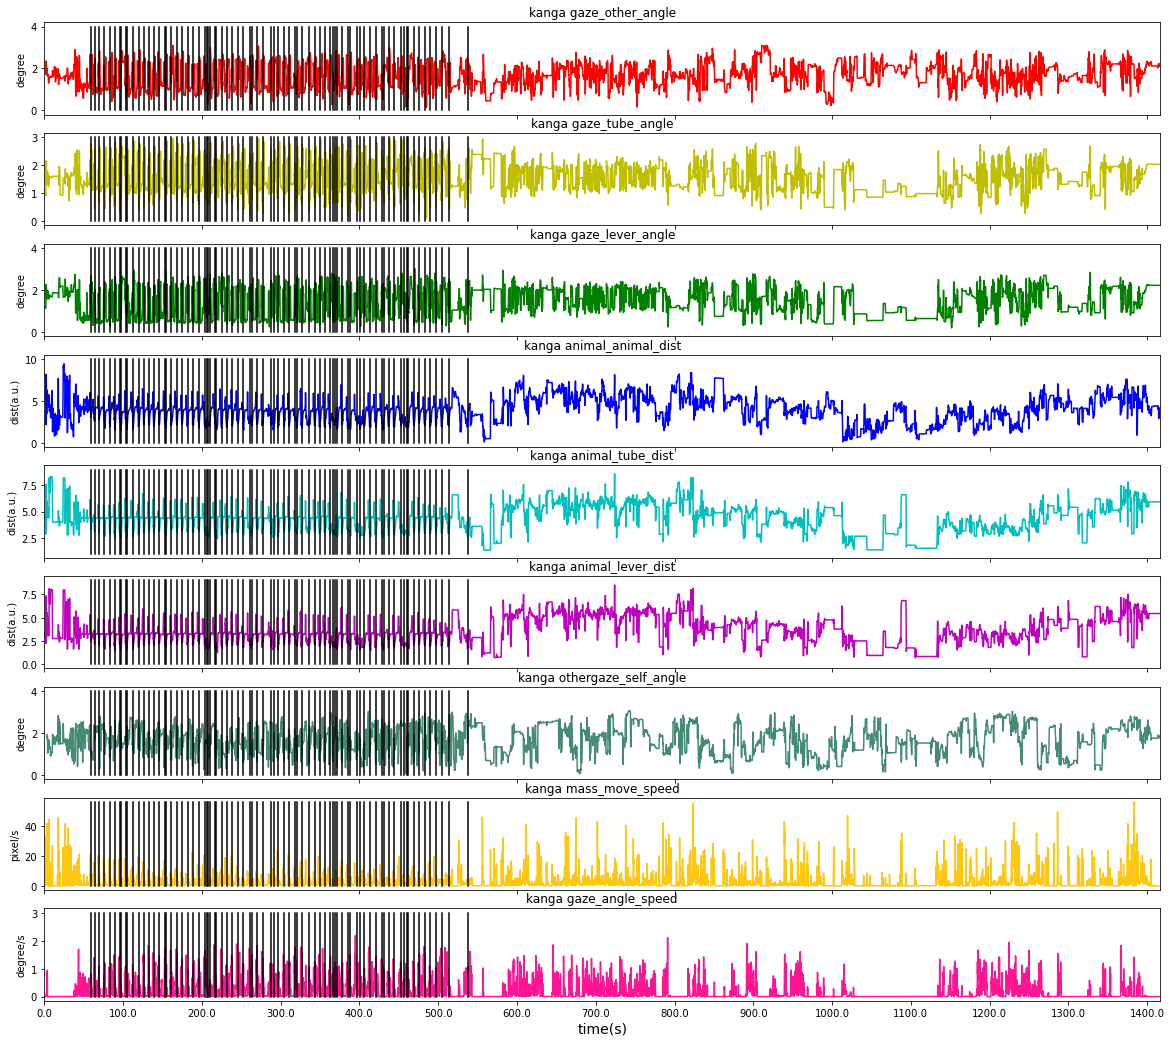

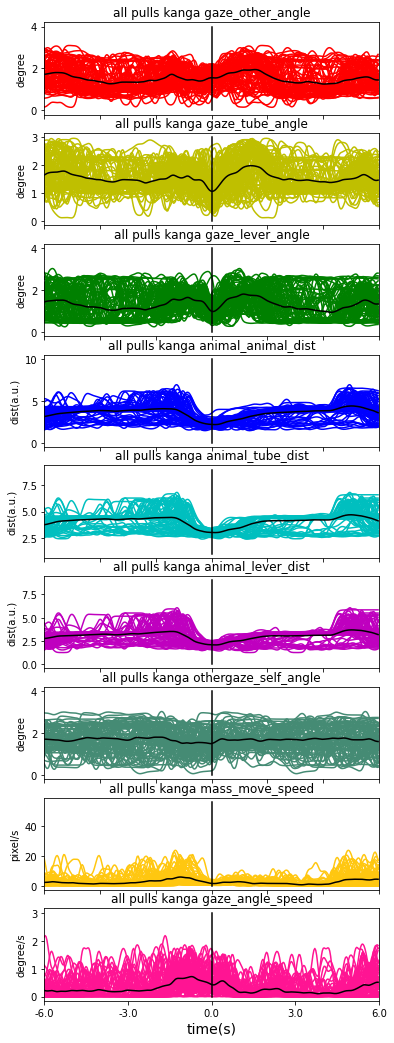

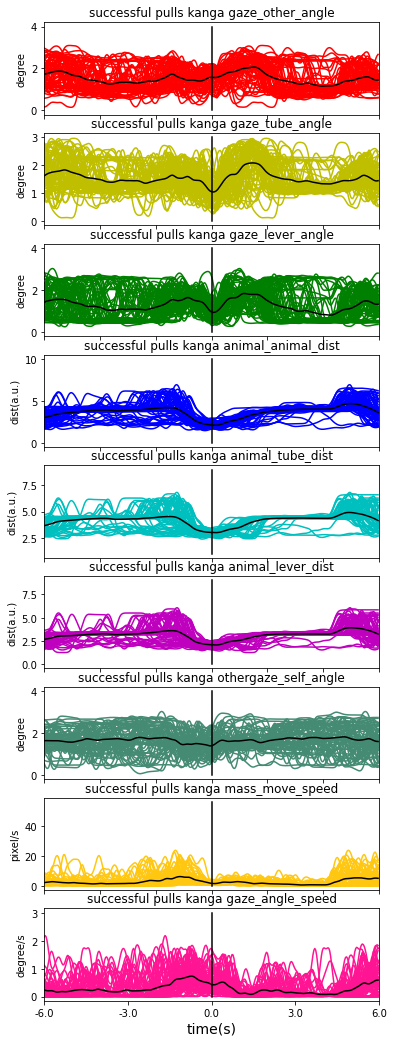

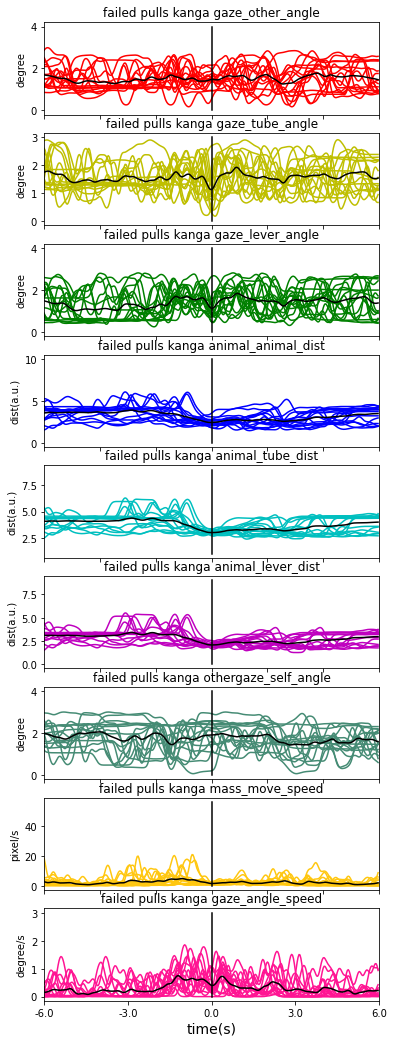

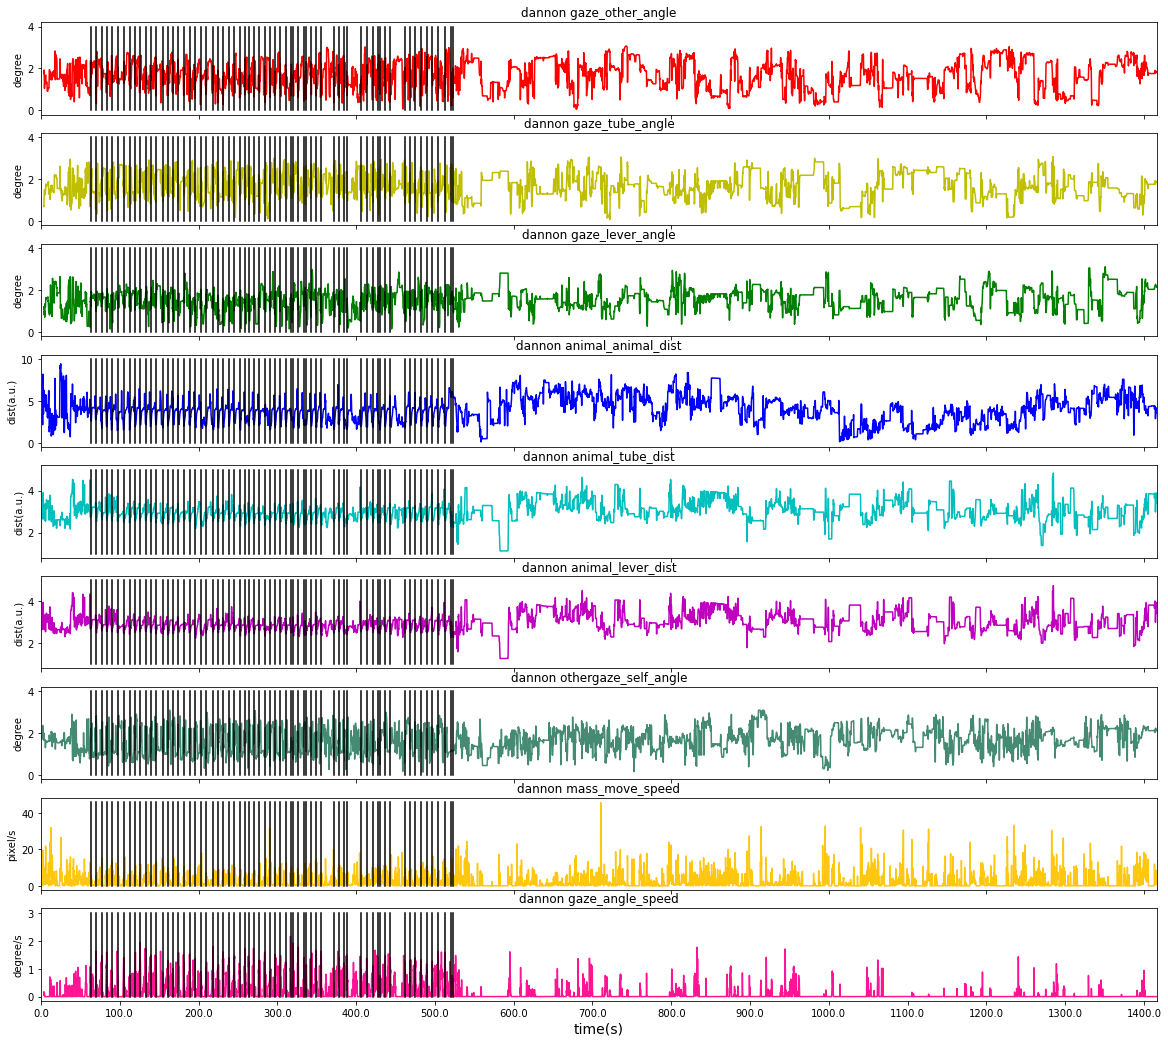

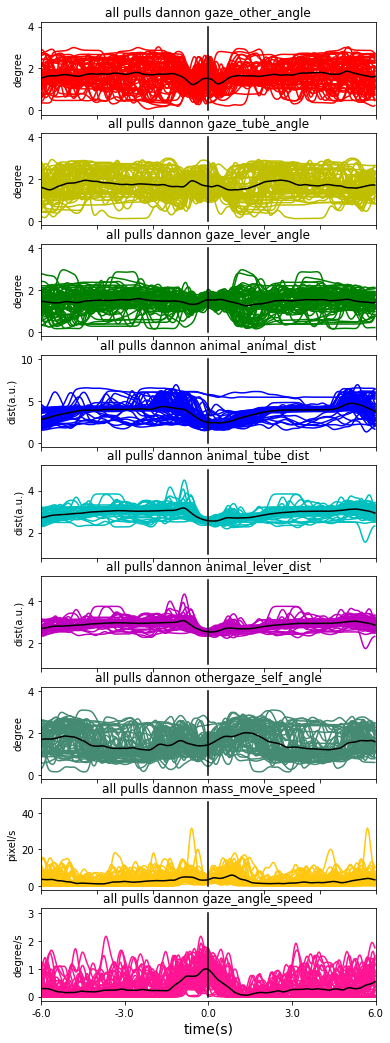

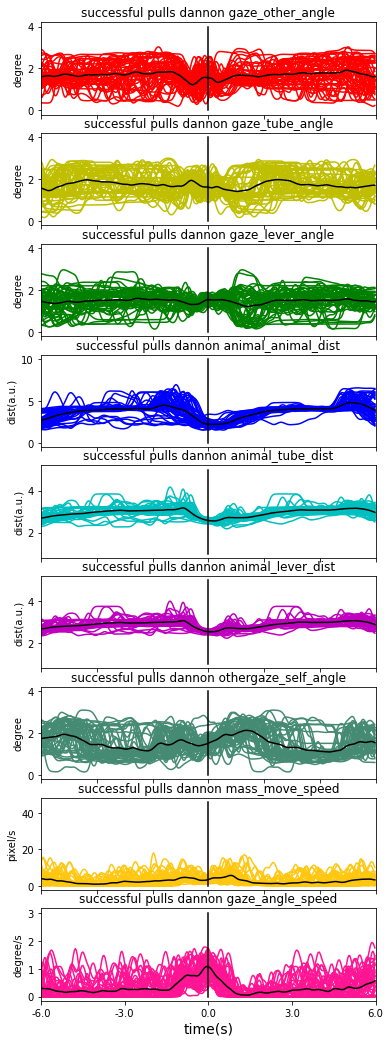

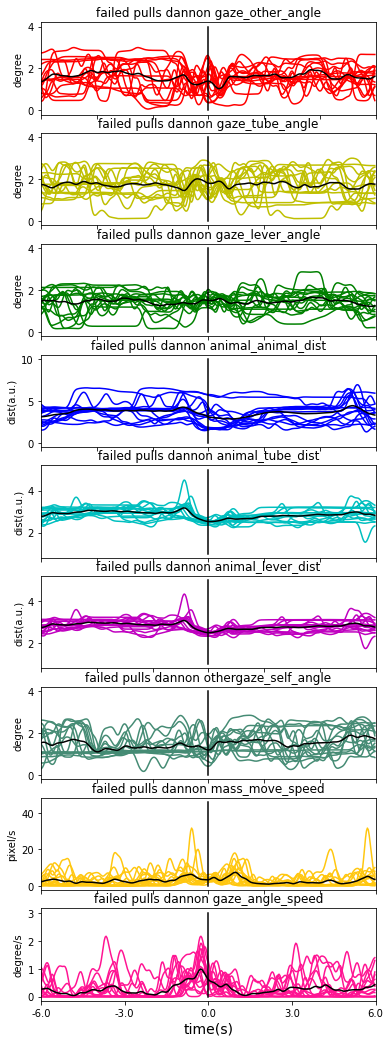

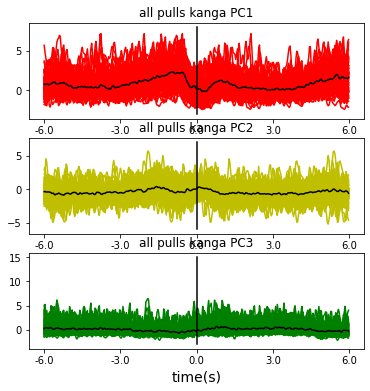

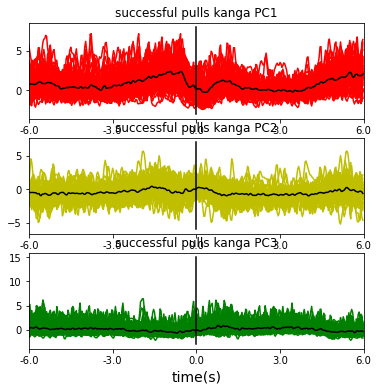

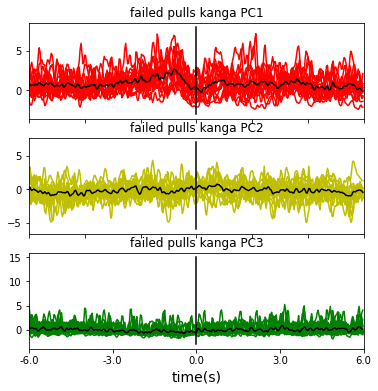

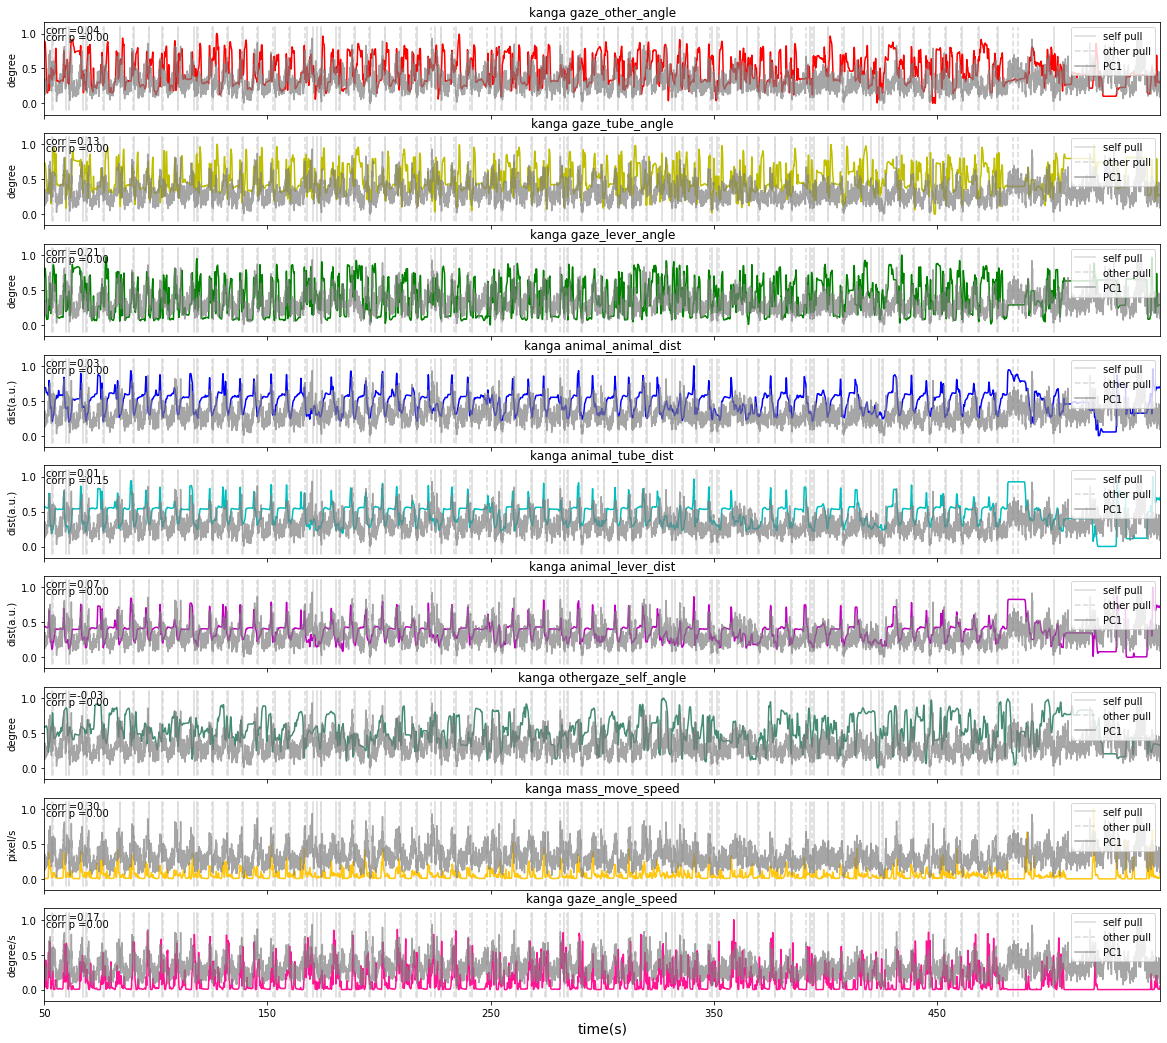

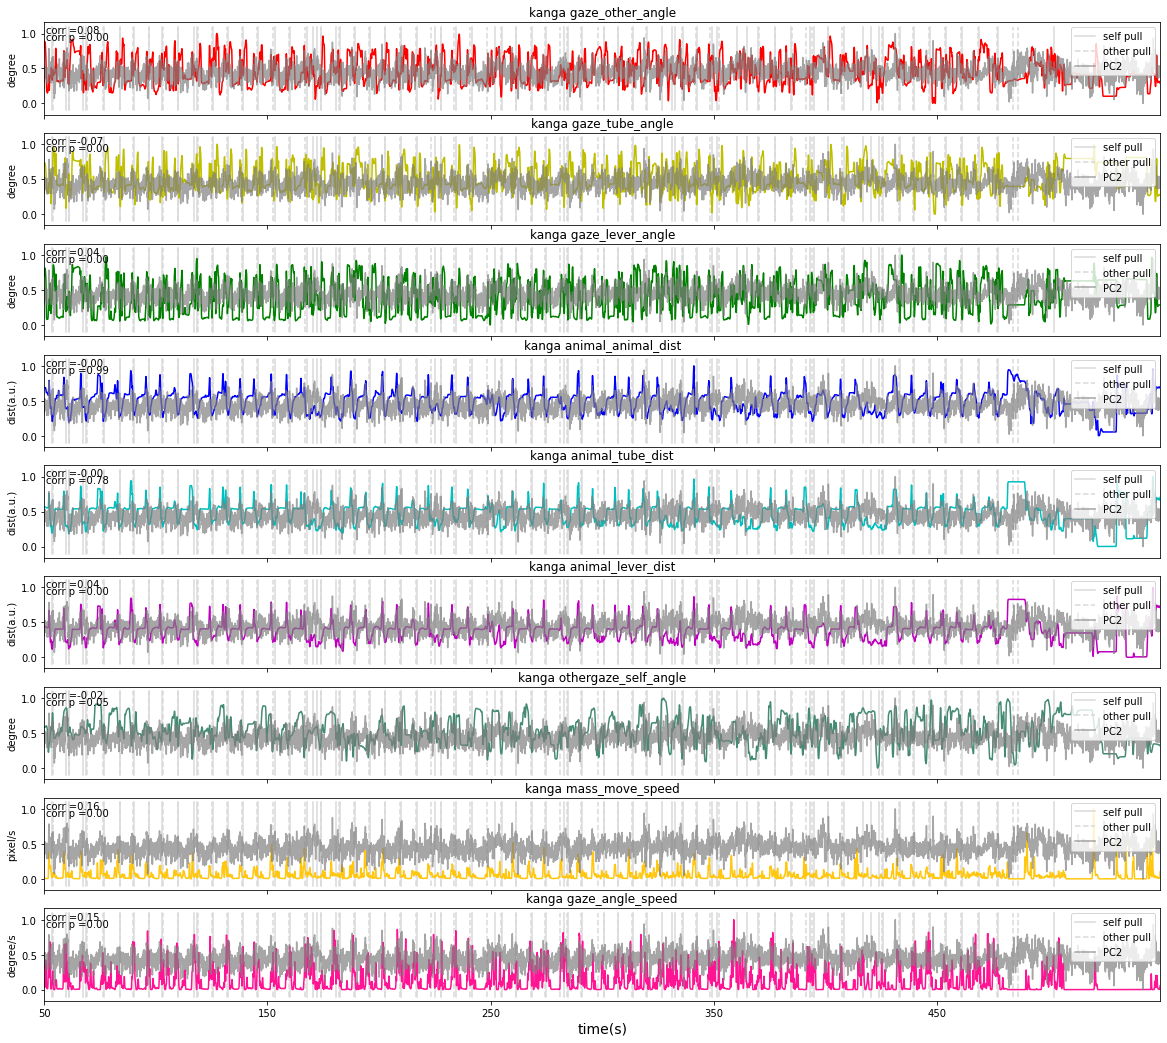

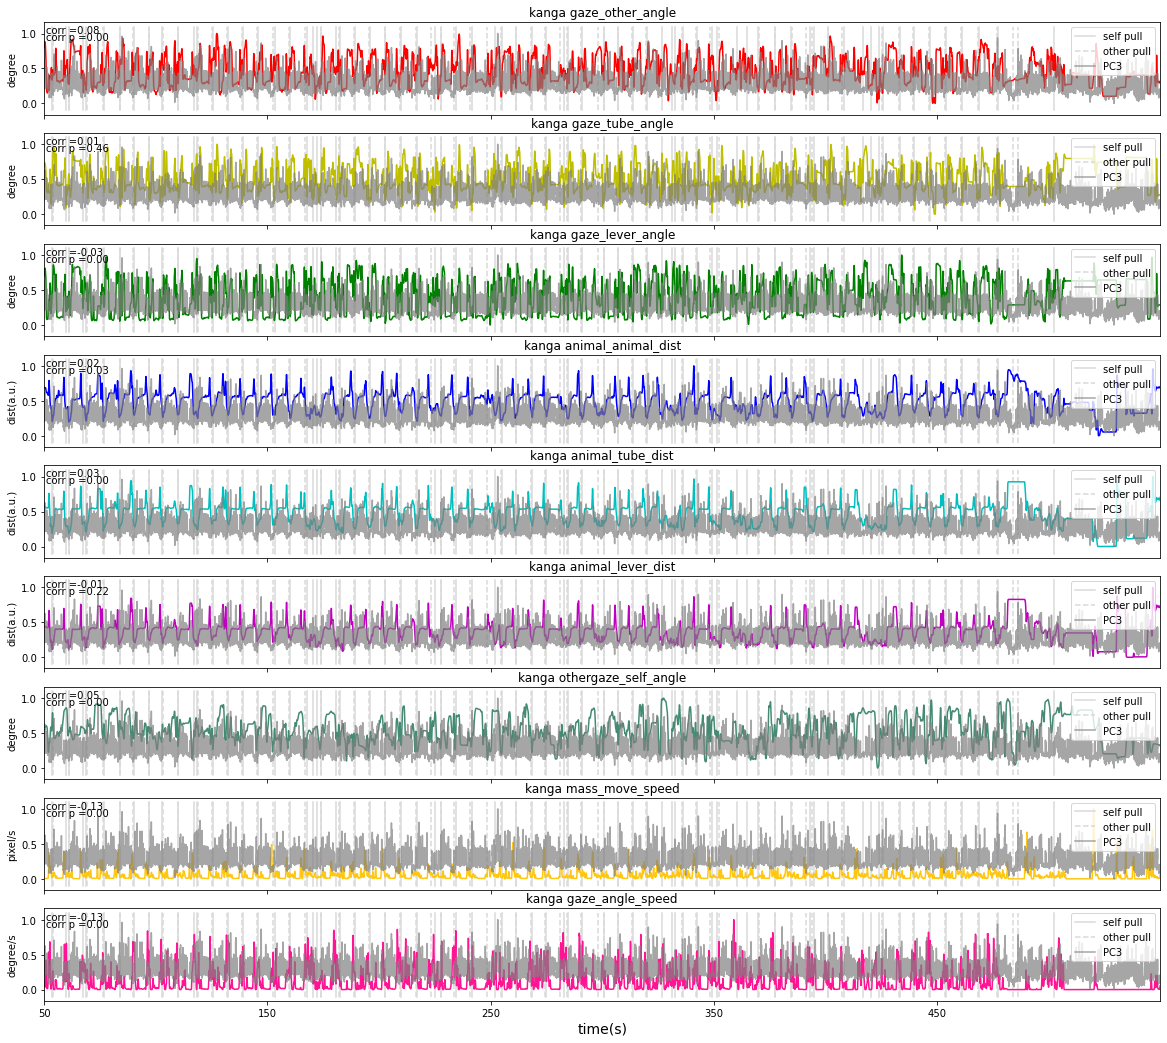

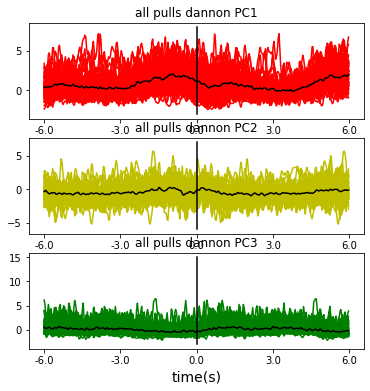

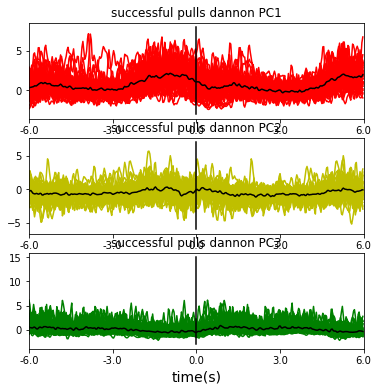

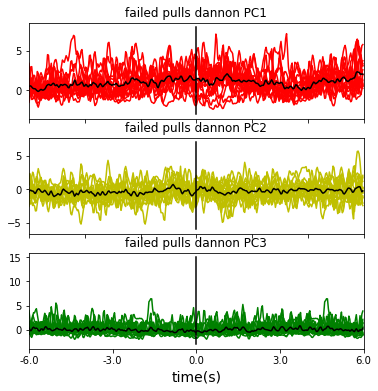

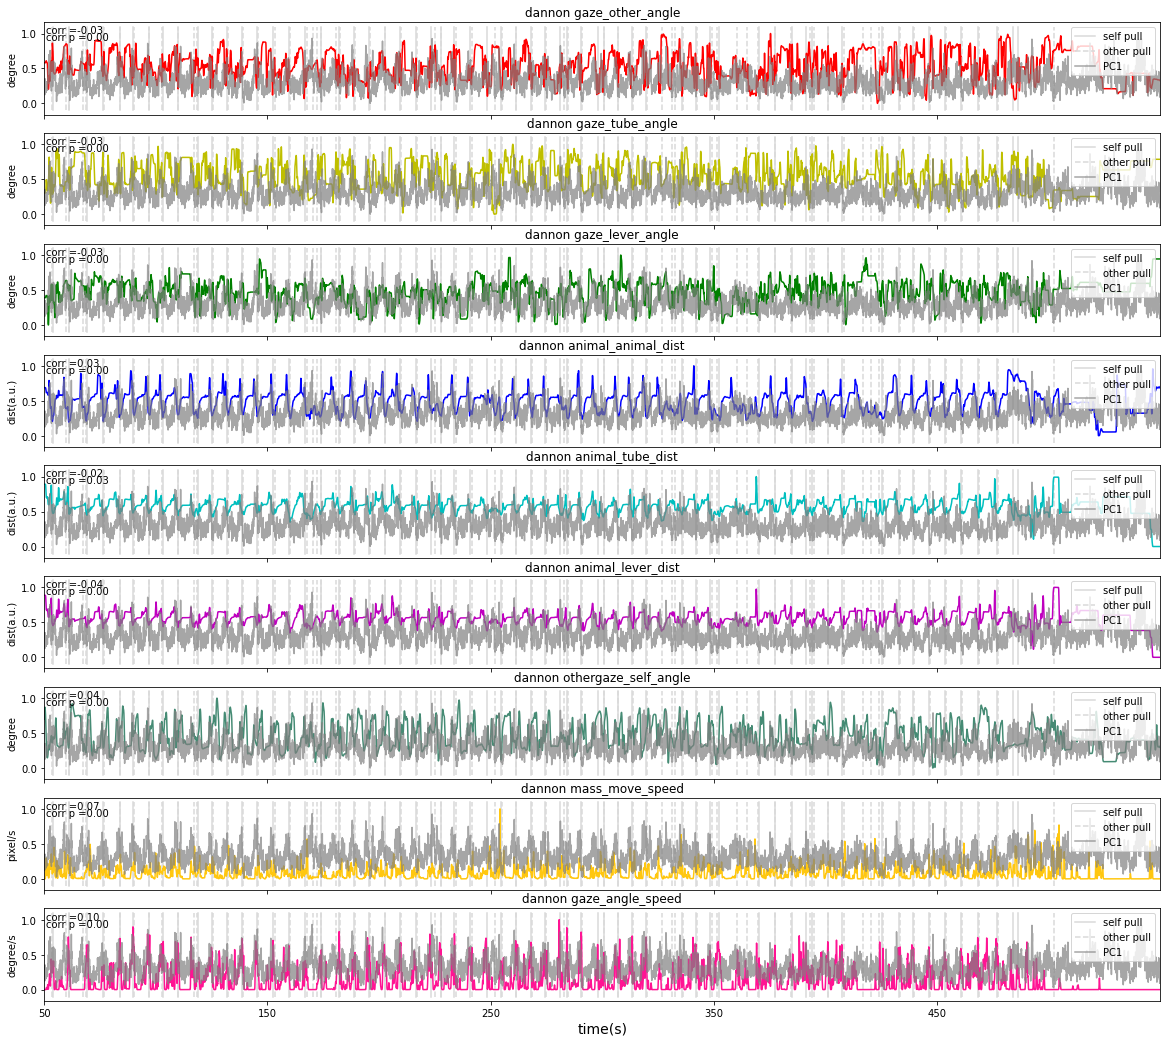

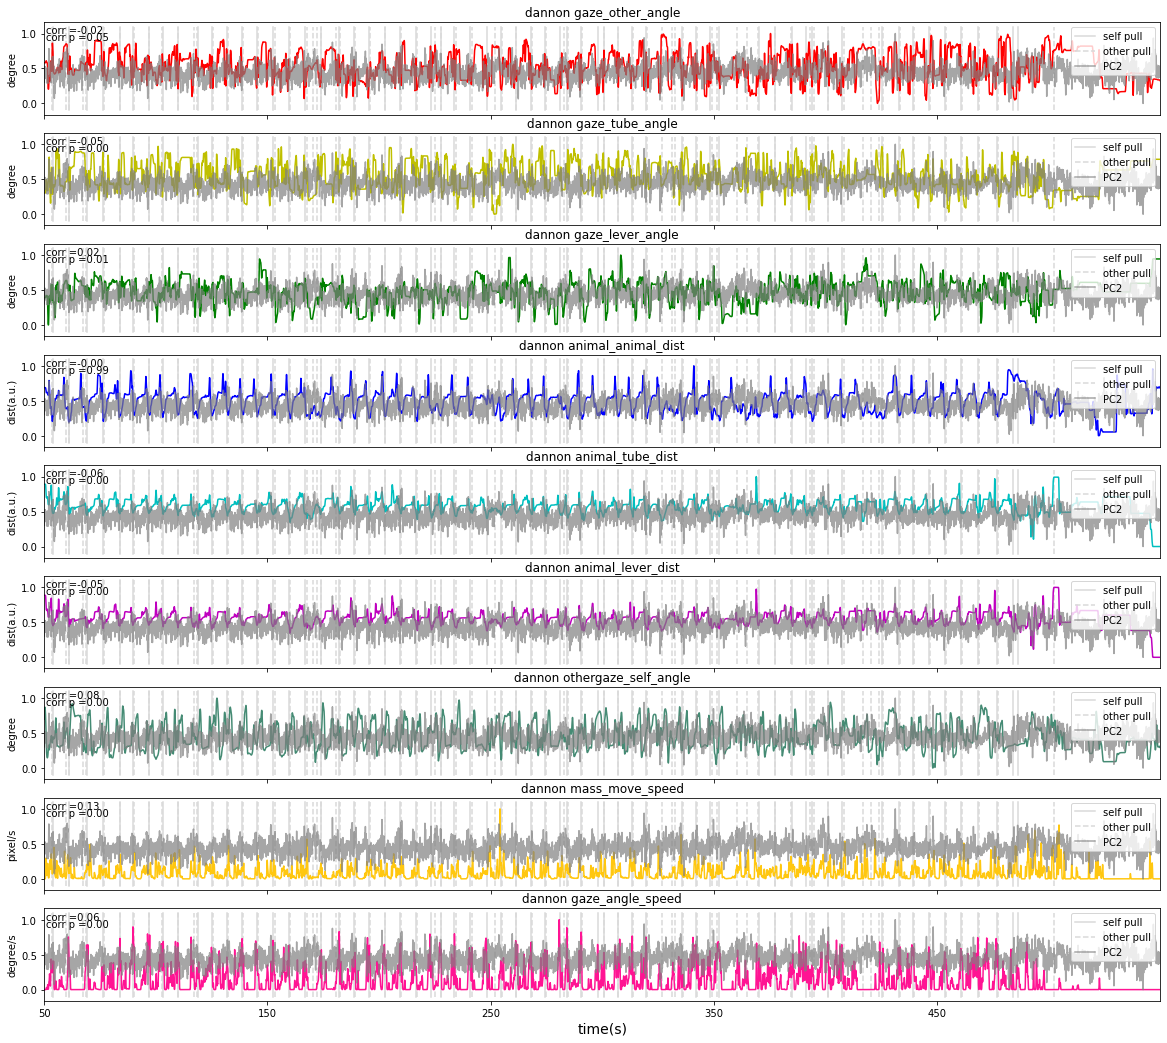

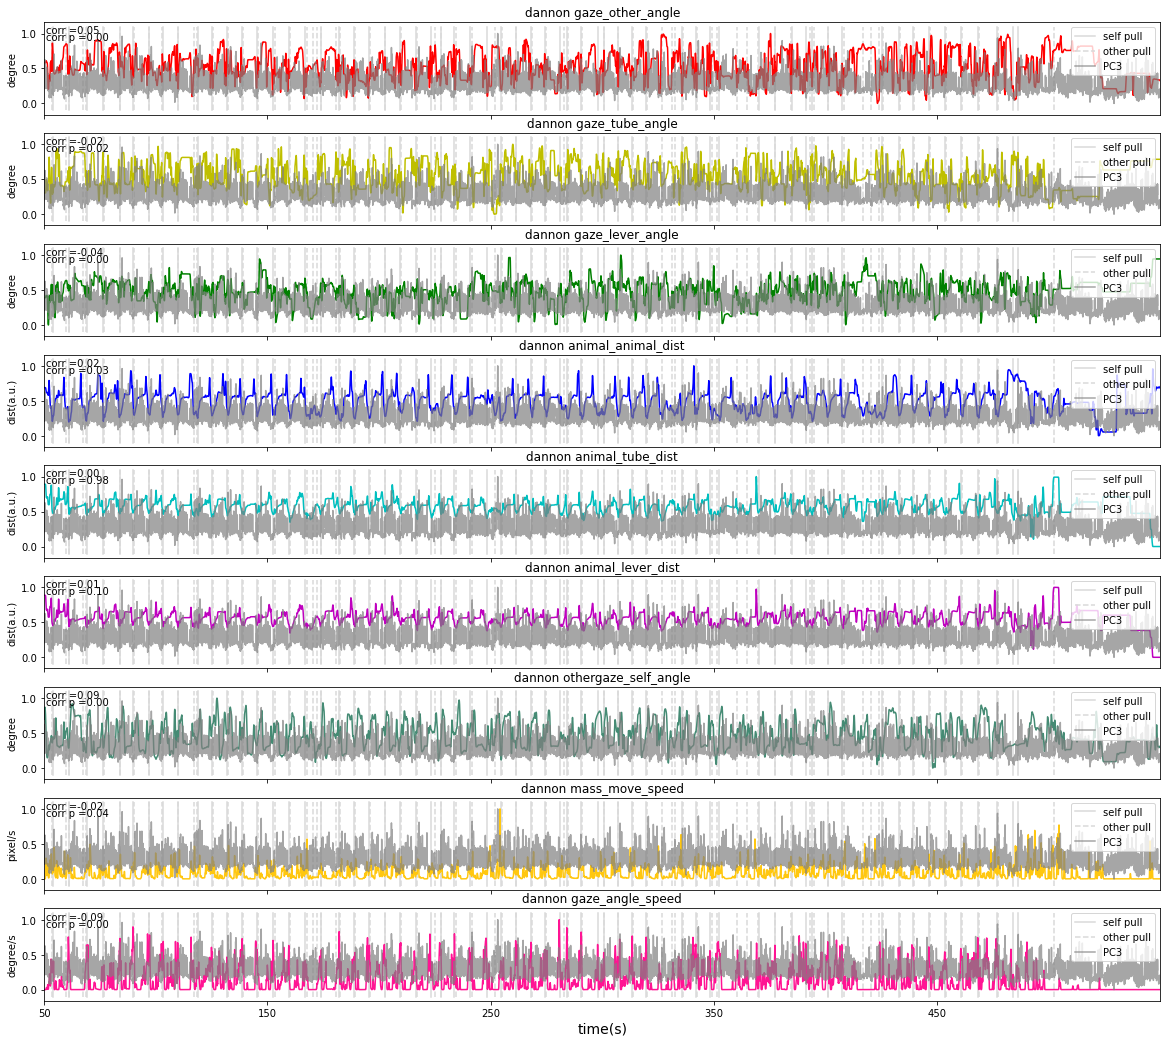

In [44]:
# basic behavior analysis (define time stamps for each bhv events, etc)
# NOTE: THIS STEP will save the data to the combinedsession_Anipose folder, since they are the same
try:
    if redo_anystep:
        dummy
    # dummy
    
    data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
        
    with open(data_saved_subfolder+'/pull_trig_events_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull_trig_events_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/pull_trig_events_succtrials_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull_trig_events_succtrials_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/pull_trig_events_errtrials_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull_trig_events_errtrials_all_dates = pickle.load(f) 
    

        
except:

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]
        neural_record_condition = neural_record_conditions[idate]
        kilosortver = kilosortvers[idate]

        # folder path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        Anipose_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/anipose_cam123_3d_h5_files/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"

        for imergepair in np.arange(0,np.shape(merge_campairs)[0],1):
            
            # should be only one merge type - "Anipose"
            merge_campair = merge_campairs[imergepair]

            # load camera tracking results
            try:
                # dummy
                if reanalyze_video:
                    print("re-analyze the data ",date_tgt)
                    dummy
                ## read
                with open(Anipose_analyzed_path + 'body_part_locs_Anipose.pkl', 'rb') as f:
                    body_part_locs_Anipose = pickle.load(f)                 
            except:
                print("did not save data for Anipose - body part tracking "+date_tgt)
                # analyze and save
                Anipose_h5_file = Anipose_analyzed_path +date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_anipose.h5"
                Anipose_h5_data = pd.read_hdf(Anipose_h5_file)
                body_part_locs_Anipose = body_part_locs_eachpair(Anipose_h5_data)
                with open(Anipose_analyzed_path + 'body_part_locs_Anipose.pkl', 'wb') as f:
                    pickle.dump(body_part_locs_Anipose, f)            
            
            min_length = np.min(list(body_part_locs_Anipose.values())[0].shape[0])
                    
            # load behavioral results
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
                # 
                with open(ni_data_json[0]) as f:
                    for line in f:
                        ni_data=json.loads(line)   
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
                #
                with open(ni_data_json[0]) as f:
                    for line in f:
                        ni_data=json.loads(line)

            # get animal info
            animal1 = session_info['lever1_animal'][0].lower()
            animal2 = session_info['lever2_animal'][0].lower()

            # get task type and cooperation threshold
            try:
                coop_thres = session_info["pulltime_thres"][0]
                tasktype = session_info["task_type"][0]
            except:
                coop_thres = 0
                tasktype = 1
            tasktypes_all_dates[idate] = tasktype
            coopthres_all_dates[idate] = coop_thres   

            # successful trial or not
            succtrial_ornot = np.array((trial_record['rewarded']>0).astype(int))
            succpull1_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==1]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
            succpull2_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==2]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
            succpulls_ornot = [succpull1_ornot,succpull2_ornot]
            
            # clean up the trial_record
            warnings.filterwarnings('ignore')
            trial_record_clean = pd.DataFrame(columns=trial_record.columns)
            for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
                # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
                trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
            trial_record_clean = trial_record_clean.reset_index(drop = True)

            # change bhv_data time to the absolute time
            time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
            for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
                ind = bhv_data["trial_number"]==itrial+1
                new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
                time_points_new["time_points_new"][ind] = new_time_itrial
            bhv_data["time_points"] = time_points_new["time_points_new"]
            bhv_data = bhv_data[bhv_data["time_points"] != 0]


            # analyze behavior results
            # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
            succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))

            trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
            #
            pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
            pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
            pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
            pulltime_diff = pulltime[1:] - pulltime[0:-1]
            interpull_intv = pulltime_diff[pullid_diff==1]
            interpull_intv = interpull_intv[interpull_intv<10]
            mean_interpull_intv = np.nanmean(interpull_intv)
            std_interpull_intv = np.nanstd(interpull_intv)
            #
            interpullintv_all_dates[idate] = mean_interpull_intv

            if np.isin(animal1,animal1_fixedorder):
                pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
                pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)
            else:
                pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)
                pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
                
            # load behavioral event results
            try:
                # dummy
                print('load social gaze with Anipose 3d of '+date_tgt)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                    output_look_ornot = pickle.load(f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                    output_allvectors = pickle.load(f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allangles.pkl', 'rb') as f:
                    output_allangles = pickle.load(f)  
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                    output_key_locations = pickle.load(f)
            except:
                print('analyze social gaze with Anipose 3d only of '+date_tgt)
                # get social gaze information 
                output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_Anipose(body_part_locs_Anipose,min_length,angle_thres,with_tubelever)
                output_key_locations = find_socialgaze_timepoint_Anipose_2(body_part_locs_Anipose,min_length,angle_thres,with_tubelever)
               
                # save data
                current_dir = data_saved_folder+'/bhv_events_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                    pickle.dump(output_look_ornot, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                    pickle.dump(output_allvectors, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allangles.pkl', 'wb') as f:
                    pickle.dump(output_allangles, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                    pickle.dump(output_key_locations, f)
                
             
            look_at_face_or_not_Anipose = output_look_ornot['look_at_face_or_not_Anipose']
            look_at_selftube_or_not_Anipose = output_look_ornot['look_at_selftube_or_not_Anipose']
            look_at_selflever_or_not_Anipose = output_look_ornot['look_at_selflever_or_not_Anipose']
            look_at_othertube_or_not_Anipose = output_look_ornot['look_at_othertube_or_not_Anipose']
            look_at_otherlever_or_not_Anipose = output_look_ornot['look_at_otherlever_or_not_Anipose']
            # change the unit to second, and aligned to session start
            session_start_time = session_start_times[idate]
            look_at_face_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_selflever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selflever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_selftube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selftube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 
            look_at_otherlever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_othertube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_othertube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 

            look_at_Anipose = {"face":look_at_face_or_not_Anipose,"selflever":look_at_selflever_or_not_Anipose,
                               "selftube":look_at_selftube_or_not_Anipose,"otherlever":look_at_otherlever_or_not_Anipose,
                               "othertube":look_at_othertube_or_not_Anipose} 
            
            # find time point of behavioral events
            output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_Anipose(bhv_data,look_at_Anipose)
            time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
            time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
            oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
            oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
            mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
            mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            timepoint_lever1 = output_time_points_levertube['time_point_lookatlever1']   
            timepoint_lever2 = output_time_points_levertube['time_point_lookatlever2']   
            timepoint_tube1 = output_time_points_levertube['time_point_lookattube1']   
            timepoint_tube2 = output_time_points_levertube['time_point_lookattube2']   
                
            # define successful pulls and failed pulls
            trialnum_succ = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']>0])
            bhv_data_succ = bhv_data[np.isin(bhv_data['trial_number'],trialnum_succ)]
            #
            time_point_pull1_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==1]
            time_point_pull2_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==2]
            time_point_pull1_succ = np.round(time_point_pull1_succ,1)
            time_point_pull2_succ = np.round(time_point_pull2_succ,1)
            #
            trialnum_fail = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']==0])
            bhv_data_fail = bhv_data[np.isin(bhv_data['trial_number'],trialnum_fail)]
            #
            time_point_pull1_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==1]
            time_point_pull2_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==2]
            time_point_pull1_fail = np.round(time_point_pull1_fail,1)
            time_point_pull2_fail = np.round(time_point_pull2_fail,1)
            # 
            time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                          "pull2_succ":time_point_pull2_succ,
                                          "pull1_fail":time_point_pull1_fail,
                                          "pull2_fail":time_point_pull2_fail,
                                        }    
            
            # # plot behavioral events
            if 0:
                if np.isin(animal1,animal1_fixedorder):
                    plot_bhv_events_levertube(date_tgt+merge_campair,animal1, animal2, session_start_time, totalsess_time, 
                                              time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2,
                                              timepoint_lever1,timepoint_lever2,timepoint_tube1,timepoint_tube2)
                else:
                    plot_bhv_events_levertube(date_tgt+merge_campair,animal2, animal1, session_start_time, totalsess_time, 
                                              time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1,
                                              timepoint_lever2,timepoint_lever1,timepoint_tube2,timepoint_tube1)
            #
            # save behavioral events plot
            if 0:
                current_dir = data_saved_folder+'/bhv_events_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                plt.savefig(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/'+date_tgt+"_Anipose.pdf")
  
            #
            # # old definition
            # if np.isin(animal1,animal1_fixedorder):
            #     owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            #     owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            #     mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            #     mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
            # else:
            #     owgaze1_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            #     owgaze2_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            #     mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
            #     mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            #
            # new defnition
            # <500ms counts as one gaze, gaze number per second
            if np.isin(animal1,animal1_fixedorder):
                owgaze1_num_all_dates[idate] = np.sum(oneway_gaze1[1:]-oneway_gaze1[:-1]>=0.5)/(min_length/fps)
                owgaze2_num_all_dates[idate] = np.sum(oneway_gaze2[1:]-oneway_gaze2[:-1]>=0.5)/(min_length/fps)
                mtgaze1_num_all_dates[idate] = np.sum(mutual_gaze1[1:]-mutual_gaze1[:-1]>=0.5)/(min_length/fps)
                mtgaze2_num_all_dates[idate] = np.sum(mutual_gaze2[1:]-mutual_gaze2[:-1]>=0.5)/(min_length/fps)
            else:
                owgaze1_num_all_dates[idate] = np.sum(oneway_gaze2[1:]-oneway_gaze2[:-1]>=0.5)/(min_length/fps)
                owgaze2_num_all_dates[idate] = np.sum(oneway_gaze1[1:]-oneway_gaze1[:-1]>=0.5)/(min_length/fps)
                mtgaze1_num_all_dates[idate] = np.sum(mutual_gaze2[1:]-mutual_gaze2[:-1]>=0.5)/(min_length/fps)
                mtgaze2_num_all_dates[idate] = np.sum(mutual_gaze1[1:]-mutual_gaze1[:-1]>=0.5)/(min_length/fps)
            
            
            # plot key continuous behavioral variables
            if 1:
                filepath_cont_var = data_saved_folder+'bhv_events_continuous_variables_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+date_tgt+'/'
                if not os.path.exists(filepath_cont_var):
                    os.makedirs(filepath_cont_var)
                
                savefig = 1
                pull_trig_events_summary, pull_trig_events_succtrial_summary, pull_trig_events_errtrial_summary = plot_continuous_bhv_var(filepath_cont_var+date_tgt+merge_campair,savefig, animal1, animal2, 
                                        session_start_time, min_length,succpulls_ornot,
                                        time_point_pull1, time_point_pull2,animalnames_videotrack,
                                        output_look_ornot, output_allvectors, output_allangles,output_key_locations)
                pull_trig_events_all_dates[date_tgt] = pull_trig_events_summary
                pull_trig_events_succtrials_all_dates[date_tgt] = pull_trig_events_succtrial_summary
                pull_trig_events_errtrials_all_dates[date_tgt] = pull_trig_events_errtrial_summary
                    
                
            # analyze the events interval, especially for the pull to other and other to pull interval
            # could be used for define time bin for DBN
            if 1:
                _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                             oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                #
                pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
                bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                                'pull_other_pooled': pull_other_pool_itv}
        
        
            
            # plot the tracking demo video
            if 0:      
                video_file = video_file_dir+'/'+date_tgt+'_'+animal1_filename+'_'+animal2_filename+'_anipose_bhv_demo.mp4'
                tracking_video_Anipose_events_demo(body_part_locs_Anipose,output_look_ornot,output_allvectors,output_allangles,
                                                   time_point_pull1,time_point_pull2,animalnames_videotrack,bodypartnames_videotrack,
                                                   date_tgt,animal1_filename,animal2_filename,animal1,animal2,
                                                   session_start_time,fps,nframes,video_file,withboxCorner)

                
                
            # get the neural data
            
            # session starting time compared with the neural recording
            session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
            neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
            neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset


            # load channel maps
            channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
            # channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32_kilosort4_new.mat'
            channel_map_data = scipy.io.loadmat(channel_map_file)

            # # load spike sorting results
            print('load spike data for '+neural_record_condition)
            if kilosortver == 2:
                spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            elif kilosortver == 4:
                spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            spike_time_data = np.round(spike_time_data)
            #
            if kilosortver == 2:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            elif kilosortver == 4:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            #
            if kilosortver == 2:
                channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            elif kilosortver == 4:
                channel_maps_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            #
            if kilosortver == 2:
                channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            elif kilosortver == 4:
                channel_pos_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            #
            if kilosortver == 2:
                clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            elif kilosortver == 4:
                clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            #
            # only get the spikes that are manually checked
            try:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
            except:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
            #
            clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
            #
            spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
            spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
            spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]

            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'].iloc[icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'].iloc[icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'].iloc[icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            try:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
                # channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
            except:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
                channel_to_depth[1] = channel_to_depth[1]/30-64 # make the y axis consistent
                

            # calculate the firing rate
            FR_kernel = 1/30 # in the unit of second # 1/30 same resolution as the video recording
            # FR_kernel is sent to to be this if want to explore it's relationship with continuous trackng data
            
            totalsess_time_forFR = np.floor(np.shape(output_look_ornot['look_at_face_or_not_Anipose']['dodson'])[0]/30)  # to match the total time of the video recording
            # _,FR_timepoint_allclusters,FR_allclusters,FR_zscore_allclusters = spike_analysis_FR_calculation(fps, FR_kernel, totalsess_time_forFR,
            #                                                                                                spike_clusters_data, spike_time_data)
            _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps,FR_kernel,totalsess_time_forFR,
                                                                                         spike_channels_data, spike_time_data)
            #
            # Run PCA analysis
            FR_zscore_allch_np_merged = np.array(pd.DataFrame(FR_zscore_allch).T)
            FR_zscore_allch_np_merged = FR_zscore_allch_np_merged[~np.isnan(np.sum(FR_zscore_allch_np_merged,axis=1)),:]
            # # run PCA on the entire session
            pca = PCA(n_components=3)
            FR_zscore_allch_PCs = pca.fit_transform(FR_zscore_allch_np_merged.T)
            #
            # # run PCA around the -PCAtwins to PCAtwins for each behavioral events
            PCAtwins = 5 # 5 second
            gaze_thresold = 0.5 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
            
            if 0:
                savefigs = 0 
                PCA_around_bhv_events(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull1,time_point_pull2,time_point_pulls_succfail, 
                              oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                              savefigs,data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)

                    
            # plot and PC1,2,3 traces and the continous variable traces
            if 1:
                print('plot the PC1,2,3 and continuous variable traces')
                
                savefig = 1
                save_path = data_saved_folder+"fig_for_neural_and_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/"+merge_campair+"/"+animal1_filename+"_"+animal2_filename+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                mintime_forplot = 50 # in the unit of second
                maxtime_forplot = 550 # in the unit of second
                plot_continuous_bhv_var_and_neuralFR(date_tgt,savefig,save_path, animal1, animal2, session_start_time,
                                                     min_length, mintime_forplot, maxtime_forplot, succpulls_ornot, 
                                                     time_point_pull1, time_point_pull2, animalnames_videotrack, 
                                                     output_look_ornot, output_allvectors, output_allangles, output_key_locations, 
                                                     FR_timepoint_allch, FR_zscore_allch_PCs)
                
                
    # save data
    if 1:
        data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
            
        with open(data_saved_subfolder+'/pull_trig_events_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_trig_events_all_dates, f)
        with open(data_saved_subfolder+'/pull_trig_events_succtrials_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_trig_events_succtrials_all_dates, f)
        with open(data_saved_subfolder+'/pull_trig_events_errtrials_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_trig_events_errtrials_all_dates, f)
            
            
